In [ ]:
import os
from google.colab import drive
import pickle
import joblib

import time
import numpy as np
import random

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

import tensorflow as tf
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import *
import cv2

# Data preparation

In [ ]:
# Define the function to load images
# ...
def load_images(CURRENT, CONTENTS, CATEGORIES):
    CNT_IMG = []
    for content in CONTENTS:
        for category in CATEGORIES:
            Path = os.path.join(CURRENT, content + '-' + category)
            if not os.path.exists(Path):
                print(f"Path does not exist: {Path}")
                continue
            for i, file in enumerate(os.listdir(Path)):
                img_array = cv2.imread(os.path.join(Path, file))  # 옵션을 제거하여 컬러 이미지로 읽기
                if img_array is None:
                    print(f"Could not read image: {os.path.join(Path, file)}")
                    continue
                CNT_IMG.append([img_array, CONTENTS.index(content), CATEGORIES.index(category), file])
    return CNT_IMG

# ...


# Load data
drive.mount('/content/drive')
# CURRENT = './CNT/'
CURRENT = '/content/drive/My Drive/CNT/'  # Have to change path according to your file structure
CONTENTS = ['0','0.05', '0.1', '0.2', '0.4']  # CNT Powder Content
METHODS = ['Shear', 'Sonic']
CNT_IMG = load_images(CURRENT, CONTENTS, METHODS)
print(f"Number of images loaded: {len(CNT_IMG)}")

In [ ]:
with open('/content/drive/My Drive/CNT_IMG_color.pkl', 'wb') as file:
    pickle.dump(CNT_IMG, file)

In [ ]:
# Load data
drive.mount('/content/drive')
with open('/content/drive/My Drive/CNT_IMG_color.pkl', 'rb') as file:
    CNT_IMG = pickle.load(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

## Split Data

Divide into small sizes and split into train and test datasets

In [ ]:
SMALL_IMG = []
# res = 0.188 # 0.188um/px
# 360.96 um x 203.04um
n_row = 3
n_col = 5
for img_array, content, method, name in CNT_IMG:
    for i in range(n_row):
        for k in range(n_col):
            height = int(img_array.shape[0]/n_row)
            width = int(img_array.shape[1]/n_col)
            small_img = img_array[i*height:(i+1)*height, k*width:(k+1)*width]
            SMALL_IMG.append([small_img, content, method, name])


labels_content = [img[1] for img in SMALL_IMG]
labels_method = [img[2] for img in SMALL_IMG]

labels_content = np.array(labels_content)
labels_method = np.array(labels_method)


In [ ]:
# Shuffle images to be trained well
random.seed(42)
random.shuffle(SMALL_IMG)

trainN = int(len(SMALL_IMG)*0.85)
print(trainN)

Train_Data = SMALL_IMG[:trainN]
Test_Data = SMALL_IMG[trainN:]

x_train = []
y_train = []  # second label, CNT powder content
y_train_method = []


for img_array, content, label, name in Train_Data:
    x_train.append(img_array)
    y_train.append(content)
    y_train_method.append(label)

# Change List to Numpy
x_train = np.array(x_train).reshape(trainN, height, width, 3) # (instances, height, width, depth)
y_train = np.array(y_train)
y_train_method = np.array(y_train_method)

print(x_train.shape, y_train.shape, y_train_method.shape)


x_test = []
y_test = []
y_test_method = []

for img_array, content, label, name in Test_Data:
    x_test.append(img_array)
    y_test.append(content)
    y_test_method.append(label)

x_test = np.array(x_test).reshape(-1, height, width, 3)
y_test = np.array(y_test)
y_test_method = np.array(y_test_method)

print(x_test.shape, y_test.shape)


4590
(4590, 360, 384, 3) (4590,) (4590,)
(810, 360, 384, 3) (810,)


## Convert to Histogram

In [ ]:
# 채널별 최소 및 최대값 계산
r_min, g_min, b_min = x_train[:,:,:,0].min(), x_train[:,:,:,1].min(), x_train[:,:,:,2].min()
r_max, g_max, b_max = x_train[:,:,:,0].max(), x_train[:,:,:,1].max(), x_train[:,:,:,2].max()

# x_train normalization 후에 다시 계산되지 않도록 주의해야 함

In [ ]:

def compute_histogram(img, bins=256):
      # 이미지 데이터 형식을 확인하고 필요한 경우 변환합니다.
    if img.dtype != np.uint8:
        img = img.astype('uint8')
    # Compute histogram for each channel (R, G, B)
    hist_r = cv2.calcHist([img], [0], None, [bins], [0, 256]).flatten()
    hist_g = cv2.calcHist([img], [1], None, [bins], [0, 256]).flatten()
    hist_b = cv2.calcHist([img], [2], None, [bins], [0, 256]).flatten()
    # Stack histograms to create a "histogram image"
    hist_img = np.stack([hist_r, hist_g, hist_b], axis=-1)
    # Normalize histogram
    hist_img = hist_img / hist_img.sum()
    return hist_img
# 채널별 정규화 함수
def normalize_rgb(image, r_min, r_max, g_min, g_max, b_min, b_max):
    r, g, b = cv2.split(image)
    r_norm = ((r - r_min) / (r_max - r_min)) * 255
    g_norm = ((g - g_min) / (g_max - g_min)) * 255
    b_norm = ((b - b_min) / (b_max - b_min)) * 255
    return cv2.merge([r_norm, g_norm, b_norm])


# 전체 이미지에 대한 채널별 정규화 적용
x_train_normalized = np.array([normalize_rgb(img, r_min, r_max, g_min, g_max, b_min, b_max) for img in x_train])
x_test_normalized = np.array([normalize_rgb(img, r_min, r_max, g_min, g_max, b_min, b_max) for img in x_test])

# Compute histograms for the scaled images
x_histo_train = np.array([compute_histogram(img) for img in x_train_normalized])
x_histo_test = np.array([compute_histogram(img) for img in x_test_normalized])

In [ ]:
print(x_histo_train.shape, y_train.shape)
x_histo_train[0]
x_histo_test[0]

(4590, 256, 3) (4590,)


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000

## Check for Robust

In [ ]:
import random
import cv2
import numpy as np
import pickle


# Function to adjust V channel in HSV space with random adjustment
def adjust_v_channel_randomly(img, adjustment_range):
    # Ensure the image is in 8-bit format
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)

    adjustment_value = random.randint(-adjustment_range, adjustment_range)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    v = np.clip(v + adjustment_value, 0, 255)  # Adjust V channel and ensure the values are within [0, 255]

    adjusted_hsv = np.dstack((h, s, v)).astype('uint8')
    adjusted_img = cv2.cvtColor(adjusted_hsv, cv2.COLOR_HSV2BGR)
    return adjusted_img



def compute_histogram(img, bins=256):
      # 이미지 데이터 형식을 확인하고 필요한 경우 변환합니다.
    if img.dtype != np.uint8:
        img = img.astype('uint8')
    # Compute histogram for each channel (R, G, B)
    hist_r = cv2.calcHist([img], [0], None, [bins], [0, 256]).flatten()
    hist_g = cv2.calcHist([img], [1], None, [bins], [0, 256]).flatten()
    hist_b = cv2.calcHist([img], [2], None, [bins], [0, 256]).flatten()
    # Stack histograms to create a "histogram image"
    hist_img = np.stack([hist_r, hist_g, hist_b], axis=-1)
    # Normalize histogram
    hist_img = hist_img / hist_img.sum()
    return hist_img

# 채널별 정규화 함수
def normalize_rgb(image, r_min, r_max, g_min, g_max, b_min, b_max):
    r, g, b = cv2.split(image)
    r_norm = ((r - r_min) / (r_max - r_min)) * 255
    g_norm = ((g - g_min) / (g_max - g_min)) * 255
    b_norm = ((b - b_min) / (b_max - b_min)) * 255
    return cv2.merge([r_norm, g_norm, b_norm])
# List of adjustment ranges
adjustment_ranges = [2, 4, 6, 8, 10,12,15,20]

# Loop through each adjustment range
for adj_range in adjustment_ranges:
    # Apply random V channel adjustment with specified range to test images
    x_test_adjusted_random = np.array([adjust_v_channel_randomly(img, adj_range) for img in x_test])
    # 전체 이미지에 대한 채널별 정규화 적용
    x_test_adjusted = np.array([normalize_rgb(img, r_min, r_max, g_min, g_max, b_min, b_max) for img in x_test_adjusted_random])

    # Compute histograms for the scaled images
    x_histo_test_adjusted = np.array([compute_histogram(img) for img in x_test_adjusted])

    # Save the adjusted images with the adjustment range in the filename
    filename = f'/content/drive/My Drive/x_histo_test_adjusted_{adj_range}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(x_histo_test_adjusted, file)


## One-hot Encoding

In [ ]:
def to_one_hot(labels, dimension=5):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

y_train = to_one_hot(y_train) # Transformation of train label vector
y_test = to_one_hot(y_test)   # Transformation of test label vector

In [ ]:
x_histo = x_histo_train.reshape(x_histo_train.shape[0],-1)
x_histo_test = x_histo_test.reshape(x_histo_test.shape[0],-1)


# Modelling

## ML

### 1. KNN

#### GridSearch

In [ ]:
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],  # 이웃 수
    'knn__weights': ['uniform', 'distance'],  # 가중치 유형
    'knn__metric': ['euclidean', 'manhattan']  # 거리 측정 유형
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

grid_content = GridSearchCV(pipe, param_grid, cv=5)
grid_method = GridSearchCV(pipe, param_grid, cv=5)

In [ ]:
grid_content.fit(x_histo, y_train.argmax(axis=1))
print(f"Best parameters for CONTENT: {grid_content.best_params_}")
print(f"Best cross-validation score for CONTENT: {grid_content.best_score_}")

grid_method.fit(x_histo, y_train_method)
print(f"Best parameters for METHOD: {grid_method.best_params_}")
print(f"Best cross-validation score for METHOD: {grid_method.best_score_}")

best_knn_content = grid_content.best_estimator_
best_knn_method = grid_method.best_estimator_

content_accuracy = accuracy_score(y_test.argmax(axis=1), best_knn_content.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, best_knn_method.predict(x_histo_test))

print(f"Test accuracy for CONTENT: {content_accuracy}")
print(f"Test accuracy for METHOD: {method_accuracy}")

Best parameters for CONTENT: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Best cross-validation score for CONTENT: 0.8816993464052288
Best parameters for METHOD: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
Best cross-validation score for METHOD: 0.9603485838779957
Test accuracy for CONTENT: 0.8987654320987655
Test accuracy for METHOD: 0.9666666666666667


#### Evaluate

In [ ]:
joblib.dump(best_knn_content, '/content/drive/My Drive/Results/RGB/best_knn_content_model.joblib')
joblib.dump(best_knn_method, '/content/drive/My Drive/Results/RGB/best_knn_method_model.joblib')

['/content/drive/My Drive/Results/RGB/best_knn_method_model.joblib']

In [ ]:
loaded_knn_content_model = joblib.load('/content/drive/My Drive/Results/RGB/best_knn_content_model.joblib')
loaded_knn_method_model = joblib.load('/content/drive/My Drive/Results/RGB/best_knn_method_model.joblib')

loaded_content_accuracy = accuracy_score(y_test.argmax(axis=1), loaded_knn_content_model.predict(x_histo_test))
loaded_method_accuracy = accuracy_score(y_test_method, loaded_knn_method_model.predict(x_histo_test))
print(f"Test accuracy for loaded CONTENT model: {loaded_content_accuracy}")
print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")

Test accuracy for loaded CONTENT model: 0.8987654320987655
Test accuracy for loaded METHOD model: 0.9666666666666667


In [ ]:
loaded_knn_content_model = joblib.load('/content/drive/My Drive/Results/RGB/best_knn_content_model.joblib')
loaded_knn_method_model = joblib.load('/content/drive/My Drive/Results/RGB/best_knn_method_model.joblib')
loaded_content_accuracy = accuracy_score(y_test.argmax(axis=1), loaded_knn_content_model.predict(x_histo_test))
loaded_method_accuracy = accuracy_score(y_test_method, loaded_knn_method_model.predict(x_histo_test))
print(f"Test accuracy for loaded CONTENT model: {loaded_content_accuracy}")
print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")

adjustment_ranges = [2, 4, 6, 8, 10]
for adj_range in adjustment_ranges:

  filename = f'/content/drive/My Drive/x_histo_test_adjusted_{adj_range}.pkl'
  with open(filename, 'rb') as file:
      x_histo_test_adjusted = pickle.load(file)
  x_histo_test_adjusted = x_histo_test_adjusted.reshape(x_histo_test_adjusted.shape[0],-1)
  y_pred_content_knn = loaded_knn_content_model.predict(x_histo_test_adjusted)
  y_pred_method_knn = loaded_knn_method_model.predict(x_histo_test_adjusted)
  print("KNN Model Metrics:")
  print(f"CONTENT F1 Score: {f1_score(y_test.argmax(axis=1), y_pred_content_knn, average='macro')}")

  loaded_method_accuracy = accuracy_score(y_test_method, y_pred_method_knn)
  print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")


Test accuracy for loaded CONTENT model: 0.8987654320987655
Test accuracy for loaded METHOD model: 0.9666666666666667
KNN Model Metrics:
CONTENT F1 Score: 0.874508759871801
Test accuracy for loaded METHOD model: 0.9555555555555556
KNN Model Metrics:
CONTENT F1 Score: 0.867525505061763
Test accuracy for loaded METHOD model: 0.9493827160493827
KNN Model Metrics:
CONTENT F1 Score: 0.8396949839285069
Test accuracy for loaded METHOD model: 0.9259259259259259
KNN Model Metrics:
CONTENT F1 Score: 0.8084333130516214
Test accuracy for loaded METHOD model: 0.9123456790123456
KNN Model Metrics:
CONTENT F1 Score: 0.7665185523304634
Test accuracy for loaded METHOD model: 0.8950617283950617


In [ ]:
y_pred_content_knn = loaded_knn_content_model.predict(x_histo_test)
y_pred_method_knn = loaded_knn_method_model.predict(x_histo_test)

print("KNN Model Metrics:")
print(f"CONTENT F1 Score: {f1_score(y_test.argmax(axis=1), y_pred_content_knn, average='macro')}")
print(f"METHOD F1 Score: {f1_score(y_test_method, y_pred_method_knn, average=None)}")
print(f"CONTENT Precision: {precision_score(y_test.argmax(axis=1), y_pred_content_knn, average='macro')}")
print(f"METHOD Precision: {precision_score(y_test_method, y_pred_method_knn, average=None)}")
print(f"CONTENT Recall: {recall_score(y_test.argmax(axis=1), y_pred_content_knn, average='macro')}")
print(f"METHOD Recall: {recall_score(y_test_method, y_pred_method_knn, average=None)}")
print(f"CONTENT Confusion Matrix:\n{confusion_matrix(y_test.argmax(axis=1), y_pred_content_knn)}")
print(f"METHOD Confusion Matrix:\n{confusion_matrix(y_test_method, y_pred_method_knn)}")

KNN Model Metrics:
CONTENT F1 Score: 0.8782922032465391
METHOD F1 Score: [0.96544276 0.95389049]
CONTENT Precision: 0.8751234562767876
METHOD Precision: [0.96129032 0.95942029]
CONTENT Recall: 0.8823086555896719
METHOD Recall: [0.96963124 0.94842407]
CONTENT Confusion Matrix:
[[ 88   4   3   0   0]
 [  1 163   7   1   1]
 [ 13  10 151  23   0]
 [  0   0  26 139   3]
 [  0   3   1   5 168]]
METHOD Confusion Matrix:
[[447  14]
 [ 18 331]]


#### Plot

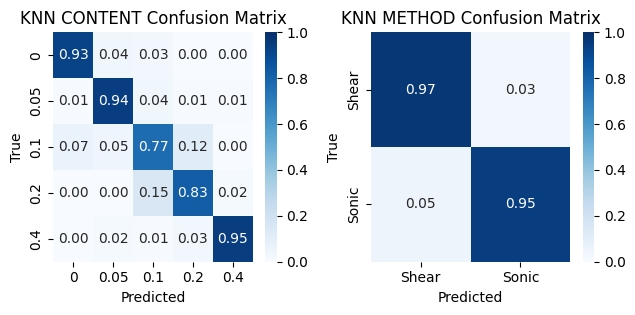

In [ ]:
cm_content_knn = confusion_matrix(y_test.argmax(axis=1), y_pred_content_knn)
cm_method_knn = confusion_matrix(y_test_method, y_pred_method_knn)

cm_content_knn_norm = cm_content_knn.astype('float') / cm_content_knn.sum(axis=1)[:, np.newaxis]
cm_method_knn_norm = cm_method_knn.astype('float') / cm_method_knn.sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.25))

CONTENTS = [0, 0.05, 0.1, 0.2, 0.4]
METHODS = ['Shear', 'Sonic']

sns.heatmap(cm_content_knn_norm, annot=True, fmt=".2f", ax=axs[0], cmap='Blues', xticklabels=CONTENTS, yticklabels=CONTENTS, vmin=0, vmax=1)
axs[0].set_title('KNN CONTENT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(cm_method_knn_norm, annot=True, fmt=".2f", ax=axs[1], cmap='Blues', xticklabels=METHODS, yticklabels=METHODS, vmin=0, vmax=1)
axs[1].set_title('KNN METHOD Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('/content/drive/My Drive/Results/RGB/confusion_matrix_knn.svg', format='svg')

### 2. SVC

#### GridSearch

In [ ]:
param_grid = {
    'svm__C': [0.1, 1, 10],  # Regularization parameter
    'svm__kernel': ['linear', 'rbf'],  # Kernel type
    'svm__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())

grid_content = GridSearchCV(pipe, param_grid, cv=5)
grid_method = GridSearchCV(pipe, param_grid, cv=5)

In [ ]:
grid_content.fit(x_histo, y_train.argmax(axis=1))
print(f"Best parameters for CONTENT: {grid_content.best_params_}")
print(f"Best cross-validation score for CONTENT: {grid_content.best_score_}")

grid_method.fit(x_histo, y_train_method)
print(f"Best parameters for METHOD: {grid_method.best_params_}")
print(f"Best cross-validation score for METHOD: {grid_method.best_score_}")

best_svm_content = grid_content.best_estimator_
best_svm_method = grid_method.best_estimator_

content_accuracy = accuracy_score(y_test.argmax(axis=1), best_svm_content.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, best_svm_method.predict(x_histo_test))

print(f"Test accuracy for CONTENT: {content_accuracy}")
print(f"Test accuracy for METHOD: {method_accuracy}")

Best parameters for CONTENT: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best cross-validation score for CONTENT: 0.8847494553376907
Best parameters for METHOD: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best cross-validation score for METHOD: 0.9610021786492375
Test accuracy for CONTENT: 0.8938271604938272
Test accuracy for METHOD: 0.9641975308641976


#### Evaluate

In [ ]:
joblib.dump(best_svm_content, '/content/drive/My Drive/Results/RGB/best_svm_content_model.joblib')
joblib.dump(best_svm_method, '/content/drive/My Drive/Results/RGB/best_svm_method_model.joblib')

['/content/drive/My Drive/Results/RGB/best_svm_method_model.joblib']

In [ ]:
loaded_svm_content_model = joblib.load('/content/drive/My Drive/Results/RGB/best_svm_content_model.joblib')
loaded_svm_method_model = joblib.load('/content/drive/My Drive/Results/RGB/best_svm_method_model.joblib')

loaded_content_accuracy = accuracy_score(y_test.argmax(axis=1), loaded_svm_content_model.predict(x_histo_test))
loaded_method_accuracy = accuracy_score(y_test_method, loaded_svm_method_model.predict(x_histo_test))
print(f"Test accuracy for loaded CONTENT model: {loaded_content_accuracy}")
print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")

Test accuracy for loaded CONTENT model: 0.8938271604938272
Test accuracy for loaded METHOD model: 0.9641975308641976


In [ ]:
y_pred_content_svm = loaded_svm_content_model.predict(x_histo_test)
y_pred_method_svm = loaded_svm_method_model.predict(x_histo_test)

print("SVM Model Metrics:")
print(f"CONTENT F1 Score: {f1_score(y_test.argmax(axis=1), y_pred_content_svm, average='macro')}")
print(f"METHOD F1 Score: {f1_score(y_test_method, y_pred_method_svm, average=None)}")
print(f"CONTENT Precision: {precision_score(y_test.argmax(axis=1), y_pred_content_svm, average='macro')}")
print(f"METHOD Precision: {precision_score(y_test_method, y_pred_method_svm, average=None)}")
print(f"CONTENT Recall: {recall_score(y_test.argmax(axis=1), y_pred_content_svm, average='macro')}")
print(f"METHOD Recall: {recall_score(y_test_method, y_pred_method_svm, average=None)}")
print(f"CONTENT Confusion Matrix:\n{confusion_matrix(y_test.argmax(axis=1), y_pred_content_svm)}")
print(f"METHOD Confusion Matrix:\n{confusion_matrix(y_test_method, y_pred_method_svm)}")

SVM Model Metrics:
CONTENT F1 Score: 0.8971616887126382
METHOD F1 Score: [0.97291441 0.96413199]
CONTENT Precision: 0.8929439012361357
METHOD Precision: [0.97186147 0.96551724]
CONTENT Recall: 0.9027607591342601
METHOD Recall: [0.97396963 0.96275072]
CONTENT Confusion Matrix:
[[ 92   2   1   0   0]
 [  2 163   5   2   1]
 [  9  10 155  22   1]
 [  0   0  20 140   8]
 [  0   1   0   2 174]]
METHOD Confusion Matrix:
[[449  12]
 [ 13 336]]


In [ ]:
loaded_svm_content_model = joblib.load('/content/drive/My Drive/Results/RGB/best_svm_content_model.joblib')
loaded_svm_method_model = joblib.load('/content/drive/My Drive/Results/RGB/best_svm_method_model.joblib')
loaded_content_accuracy = accuracy_score(y_test.argmax(axis=1), loaded_svm_content_model.predict(x_histo_test))
loaded_method_accuracy = accuracy_score(y_test_method, loaded_svm_method_model.predict(x_histo_test))
print(f"Test accuracy for loaded CONTENT model: {loaded_content_accuracy}")
print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")

adjustment_ranges = [2, 4, 6, 8, 10]
for adj_range in adjustment_ranges:

  filename = f'/content/drive/My Drive/x_histo_test_adjusted_{adj_range}.pkl'
  with open(filename, 'rb') as file:
      x_histo_test_adjusted = pickle.load(file)
  x_histo_test_adjusted = x_histo_test_adjusted.reshape(x_histo_test_adjusted.shape[0],-1)
  y_pred_content_svm = loaded_svm_content_model.predict(x_histo_test_adjusted)
  y_pred_method_svm = loaded_svm_method_model.predict(x_histo_test_adjusted)
  print("SVM Model Metrics:")
  print(f"CONTENT F1 Score: {f1_score(y_test.argmax(axis=1), y_pred_content_svm, average='macro')}")

  loaded_method_accuracy = accuracy_score(y_test_method, y_pred_method_svm)
  print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")


Test accuracy for loaded CONTENT model: 0.8938271604938272
Test accuracy for loaded METHOD model: 0.9641975308641976
SVM Model Metrics:
CONTENT F1 Score: 0.882573841526432
Test accuracy for loaded METHOD model: 0.9530864197530864
SVM Model Metrics:
CONTENT F1 Score: 0.854568791322904
Test accuracy for loaded METHOD model: 0.9530864197530864
SVM Model Metrics:
CONTENT F1 Score: 0.8312249584783853
Test accuracy for loaded METHOD model: 0.9308641975308642
SVM Model Metrics:
CONTENT F1 Score: 0.8085215648350385
Test accuracy for loaded METHOD model: 0.9061728395061729
SVM Model Metrics:
CONTENT F1 Score: 0.7067714766655959
Test accuracy for loaded METHOD model: 0.8604938271604938


#### Plot

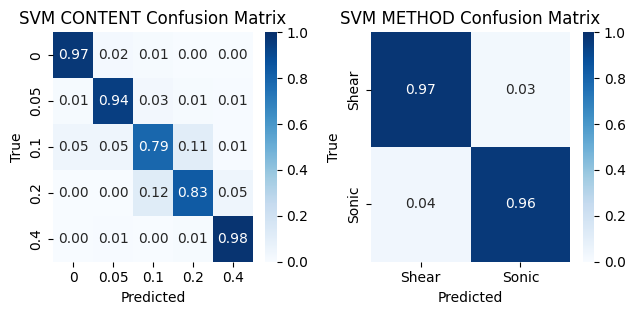

In [ ]:
cm_content_svm = confusion_matrix(y_test.argmax(axis=1), y_pred_content_svm)
cm_method_svm = confusion_matrix(y_test_method, y_pred_method_svm)

cm_content_svm_norm = cm_content_svm.astype('float') / cm_content_svm.sum(axis=1)[:, np.newaxis]
cm_method_svm_norm = cm_method_svm.astype('float') / cm_method_svm.sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.25))

CONTENTS = [0, 0.05, 0.1, 0.2, 0.4]
METHODS = ['Shear', 'Sonic']

sns.heatmap(cm_content_svm_norm, annot=True, fmt=".2f", ax=axs[0], cmap='Blues', xticklabels=CONTENTS, yticklabels=CONTENTS, vmin=0, vmax=1)
axs[0].set_title('SVM CONTENT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(cm_method_svm_norm, annot=True, fmt=".2f", ax=axs[1], cmap='Blues', xticklabels=METHODS, yticklabels=METHODS, vmin=0, vmax=1)
axs[1].set_title('SVM METHOD Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('/content/drive/My Drive/Results/RGB/confusion_matrix_svm.svg', format='svg')

### 3. RF

Try default model

In [ ]:
rfc_content = RandomForestClassifier(random_state=42)
rfc_method = RandomForestClassifier(random_state=42)

rfc_content.fit(x_histo, y_train.argmax(axis=1))
rfc_method.fit(x_histo, y_train_method)

content_accuracy = accuracy_score(y_test.argmax(axis=1), rfc_content.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, rfc_method.predict(x_histo_test))

print(f"Test accuracy for CONTENT: {content_accuracy}")
print(f"Test accuracy for METHOD: {method_accuracy}")

Test accuracy for CONTENT: 0.9135802469135802
Test accuracy for METHOD: 0.9753086419753086


#### GridSearch

In [ ]:
params = { 'n_estimators' : [100, 200],
           'max_depth' : [5, 10, 15, 20],
           'min_samples_leaf' : [4, 6, 8, 12, 16],
           'min_samples_split' : [4, 6, 8, 12, 16]
            }

grid_content = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5, n_jobs=-1)
grid_method = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5, n_jobs=-1)

In [ ]:
grid_content.fit(x_histo, y_train.argmax(axis=1))
print(f"Best parameters for CONTENT: {grid_content.best_params_}")
print(f"Best cross-validation score for CONTENT: {grid_content.best_score_}")

grid_method.fit(x_histo, y_train_method)
print(f"Best parameters for METHOD: {grid_method.best_params_}")
print(f"Best cross-validation score for METHOD: {grid_method.best_score_}")

best_rf_content = grid_content.best_estimator_
best_rf_method = grid_method.best_estimator_

content_accuracy = accuracy_score(y_test.argmax(axis=1), best_rf_content.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, best_rf_method.predict(x_histo_test))

print(f"Test accuracy for CONTENT: {content_accuracy}")
print(f"Test accuracy for METHOD: {method_accuracy}")

Best parameters for CONTENT: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 200}
Best cross-validation score for CONTENT: 0.9076252723311548
Best parameters for METHOD: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100}
Best cross-validation score for METHOD: 0.9692810457516339
Test accuracy for CONTENT: 0.908641975308642
Test accuracy for METHOD: 0.9753086419753086


In [ ]:
joblib.dump(best_rf_content, '/content/drive/My Drive/Results/RGB/best_rf_content_model.joblib')
joblib.dump(best_rf_method, '/content/drive/My Drive/Results/RGB/best_rf_method_model.joblib')

['/content/drive/My Drive/Results/RGB/best_rf_method_model.joblib']

#### Evaluate

In [ ]:
loaded_rf_content_model = joblib.load('/content/drive/My Drive/Results/RGB/best_rf_content_model.joblib')
loaded_rf_method_model = joblib.load('/content/drive/My Drive/Results/RGB/best_rf_method_model.joblib')

loaded_content_accuracy = accuracy_score(y_test.argmax(axis=1), loaded_rf_content_model.predict(x_histo_test))
loaded_method_accuracy = accuracy_score(y_test_method, loaded_rf_method_model.predict(x_histo_test))
print(f"Test accuracy for loaded CONTENT model: {loaded_content_accuracy}")
print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")

Test accuracy for loaded CONTENT model: 0.908641975308642
Test accuracy for loaded METHOD model: 0.9753086419753086


In [ ]:
y_pred_content_rf = loaded_rf_content_model.predict(x_histo_test)
y_pred_method_rf = loaded_rf_method_model.predict(x_histo_test)

print("RF Model Metrics:")
print(f"CONTENT F1 Score: {f1_score(y_test.argmax(axis=1), y_pred_content_rf, average='macro')}")
print(f"METHOD F1 Score: {f1_score(y_test_method, y_pred_method_rf, average=None)}")
print(f"CONTENT Precision: {precision_score(y_test.argmax(axis=1), y_pred_content_rf, average='macro')}")
print(f"METHOD Precision: {precision_score(y_test_method, y_pred_method_rf, average=None)}")
print(f"CONTENT Recall: {recall_score(y_test.argmax(axis=1), y_pred_content_rf, average='macro')}")
print(f"METHOD Recall: {recall_score(y_test_method, y_pred_method_rf, average=None)}")
print(f"CONTENT Confusion Matrix:\n{confusion_matrix(y_test.argmax(axis=1), y_pred_content_rf)}")
print(f"METHOD Confusion Matrix:\n{confusion_matrix(y_test_method, y_pred_method_rf)}")

RF Model Metrics:
CONTENT F1 Score: 0.9150012634314602
METHOD F1 Score: [0.97840173 0.97118156]
CONTENT Precision: 0.9145793413786534
METHOD Precision: [0.97419355 0.97681159]
CONTENT Recall: 0.9155495517933666
METHOD Recall: [0.98264642 0.96561605]
CONTENT Confusion Matrix:
[[ 92   2   1   0   0]
 [  1 164   6   1   1]
 [  2  10 163  22   0]
 [  0   1  23 142   2]
 [  0   1   0   1 175]]
METHOD Confusion Matrix:
[[453   8]
 [ 12 337]]


In [ ]:
loaded_rf_content_model = joblib.load('/content/drive/My Drive/Results/RGB/best_rf_content_model.joblib')
loaded_rf_method_model = joblib.load('/content/drive/My Drive/Results/RGB/best_rf_method_model.joblib')

loaded_content_accuracy = accuracy_score(y_test.argmax(axis=1), loaded_rf_content_model.predict(x_histo_test))
loaded_method_accuracy = accuracy_score(y_test_method, loaded_rf_method_model.predict(x_histo_test))
print(f"Test accuracy for loaded CONTENT model: {loaded_content_accuracy}")
print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")

adjustment_ranges = [2, 4, 6, 8, 10]
for adj_range in adjustment_ranges:

  filename = f'/content/drive/My Drive/x_histo_test_adjusted_{adj_range}.pkl'
  with open(filename, 'rb') as file:
      x_histo_test_adjusted = pickle.load(file)
  x_histo_test_adjusted = x_histo_test_adjusted.reshape(x_histo_test_adjusted.shape[0],-1)

  y_pred_content_rf = loaded_rf_content_model.predict(x_histo_test_adjusted)
  y_pred_method_rf = loaded_rf_method_model.predict(x_histo_test_adjusted)

  print(f"CONTENT F1 Score: {f1_score(y_test.argmax(axis=1), y_pred_content_rf, average='macro')}")
  loaded_method_accuracy = accuracy_score(y_test_method, y_pred_method_rf)
  print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")


Test accuracy for loaded CONTENT model: 0.9185185185185185
Test accuracy for loaded METHOD model: 0.9679012345679012
CONTENT F1 Score: 0.9114493336311519
Test accuracy for loaded METHOD model: 0.9679012345679012
CONTENT F1 Score: 0.9056962156001311
Test accuracy for loaded METHOD model: 0.9567901234567902
CONTENT F1 Score: 0.8805986308109656
Test accuracy for loaded METHOD model: 0.9481481481481482
CONTENT F1 Score: 0.8332632761121077
Test accuracy for loaded METHOD model: 0.9358024691358025
CONTENT F1 Score: 0.8168477690516823
Test accuracy for loaded METHOD model: 0.9160493827160494


#### Plot

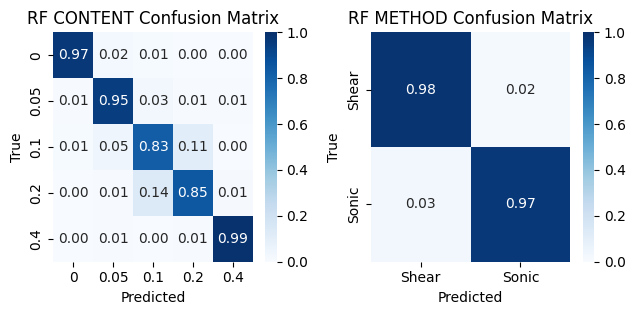

In [ ]:
cm_content_rf = confusion_matrix(y_test.argmax(axis=1), y_pred_content_rf)
cm_method_rf = confusion_matrix(y_test_method, y_pred_method_rf)

cm_content_rf_norm = cm_content_rf.astype('float') / cm_content_rf.sum(axis=1)[:, np.newaxis]
cm_method_rf_norm = cm_method_rf.astype('float') / cm_method_rf.sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.25))

CONTENTS = [0, 0.05, 0.1, 0.2, 0.4]
METHODS = ['Shear', 'Sonic']

sns.heatmap(cm_content_rf_norm, annot=True, fmt=".2f", ax=axs[0], cmap='Blues', xticklabels=CONTENTS, yticklabels=CONTENTS, vmin=0, vmax=1)
axs[0].set_title('RF CONTENT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(cm_method_rf_norm, annot=True, fmt=".2f", ax=axs[1], cmap='Blues', xticklabels=METHODS, yticklabels=METHODS, vmin=0, vmax=1)
axs[1].set_title('RF METHOD Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('/content/drive/My Drive/Results/RGB/confusion_matrix_rf.svg', format='svg')

### 4. LGB

Try default model

In [ ]:
lgbm_content = lgb.LGBMClassifier(random_state=42)
lgbm_method = lgb.LGBMClassifier(random_state=42)

lgbm_content.fit(x_histo, y_train.argmax(axis=1))
lgbm_method.fit(x_histo, y_train_method)

content_accuracy = accuracy_score(y_test.argmax(axis=1), lgbm_content.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, lgbm_method.predict(x_histo_test))

print(f"Test accuracy for CONTENT: {content_accuracy}")
print(f"Test accuracy for METHOD: {method_accuracy}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121384
[LightGBM] [Info] Number of data points in the train set: 4590, number of used features: 630
[LightGBM] [Info] Start training from score -2.207077
[LightGBM] [Info] Start training from score -1.497238
[LightGBM] [Info] Start training from score -1.520885
[LightGBM] [Info] Start training from score -1.492381
[LightGBM] [Info] Start training from score -1.501141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2051, number of negative: 2539
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121384
[LightGBM] [Info] Number of data points in the train set: 4590, number of used features: 630
[Lig

#### GridSearch

In [ ]:
params = {
    "max_depth": [25,50,-1],
    "num_leaves": [20,31,40],
}

# GridSearchCV 정의
grid_content = GridSearchCV(lgb.LGBMClassifier(random_state=42, verbose=2), params, cv=3, n_jobs=-1, verbose=3)
grid_method = GridSearchCV(lgb.LGBMClassifier(random_state=42, verbose=2), params, cv=3, n_jobs=-1, verbose=3)

In [ ]:
grid_content.fit(x_histo, y_train.argmax(axis=1))
print(f"Best parameters for CONTENT: {grid_content.best_params_}")
print(f"Best cross-validation score for CONTENT: {grid_content.best_score_}")

grid_method.fit(x_histo, y_train_method)
print(f"Best parameters for METHOD: {grid_method.best_params_}")
print(f"Best cross-validation score for METHOD: {grid_method.best_score_}")

best_lgb_content = grid_content.best_estimator_
best_lgb_method = grid_method.best_estimator_

content_accuracy = accuracy_score(y_test.argmax(axis=1), best_lgb_content.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, best_lgb_method.predict(x_histo_test))

print(f"Test accuracy for CONTENT: {content_accuracy}")
print(f"Test accuracy for METHOD: {method_accuracy}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.870960
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.297307
[LightGBM] [Debug] init for col-wise cost 0.002396 seconds, init for row-wise cost 0.013396 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121384
[LightGBM] [Info] Number of data points in the train set: 4590, number of used features: 630
[LightGBM] [Info] Start training from score -2.207077
[LightGBM] [Info] Start training from score -1.497238
[LightGBM] [Info] Start training from score -1.520885
[LightGBM] [Info] Start training from score -1.492381
[LightGBM] [Info] Start training from score -1.501141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 

In [ ]:
joblib.dump(best_lgb_content, '/content/drive/My Drive/Results/RGB/best_lgb_content_model.joblib')
joblib.dump(best_lgb_method, '/content/drive/My Drive/Results/RGB/best_lgb_method_model.joblib')

['/content/drive/My Drive/Results/RGB/best_lgb_method_model.joblib']

#### Evaluate

In [ ]:

best_lgb_content = joblib.load('/content/drive/My Drive/Results/RGB/best_lgb_content_model.joblib')
best_lgb_method = joblib.load('/content/drive/My Drive/Results/RGB/best_lgb_method_model.joblib')


In [ ]:
content_accuracy = accuracy_score(y_test.argmax(axis=1), best_lgb_content.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, best_lgb_method.predict(x_histo_test))
print(f"Test accuracy for CONTENT model: {content_accuracy}")
print(f"Test accuracy for METHOD model: {method_accuracy}")

Test accuracy for CONTENT model: 0.9185185185185185
Test accuracy for METHOD model: 0.9765432098765432


In [ ]:
y_pred_content_lgb = best_lgb_content.predict(x_histo_test)
y_pred_method_lgb = best_lgb_method.predict(x_histo_test)

print("LGB Model Metrics:")
print(f"CONTENT F1 Score: {f1_score(y_test.argmax(axis=1), y_pred_content_lgb, average='macro')}")
print(f"METHOD F1 Score: {f1_score(y_test_method, y_pred_method_lgb, average=None)}")
print(f"CONTENT Precision: {precision_score(y_test.argmax(axis=1), y_pred_content_lgb, average='macro')}")
print(f"METHOD Precision: {precision_score(y_test_method, y_pred_method_lgb, average=None)}")
print(f"CONTENT Recall: {recall_score(y_test.argmax(axis=1), y_pred_content_lgb, average='macro')}")
print(f"METHOD Recall: {recall_score(y_test_method, y_pred_method_lgb, average=None)}")
print(f"CONTENT Confusion Matrix:\n{confusion_matrix(y_test.argmax(axis=1), y_pred_content_lgb)}")
print(f"METHOD Confusion Matrix:\n{confusion_matrix(y_test_method, y_pred_method_lgb)}")

LGB Model Metrics:
CONTENT F1 Score: 0.9249805007619685
METHOD F1 Score: [0.97945946 0.97266187]
CONTENT Precision: 0.9259883257383897
METHOD Precision: [0.9762931  0.97687861]
CONTENT Recall: 0.9240480005940317
METHOD Recall: [0.98264642 0.96848138]
CONTENT Confusion Matrix:
[[ 92   2   1   0   0]
 [  0 165   5   2   1]
 [  1   7 169  20   0]
 [  0   1  21 144   2]
 [  0   1   1   1 174]]
METHOD Confusion Matrix:
[[453   8]
 [ 11 338]]


In [ ]:
loaded_rf_content_model = joblib.load('/content/drive/My Drive/Results/RGB/best_lgb_content_model.joblib')
loaded_rf_method_model = joblib.load('/content/drive/My Drive/Results/RGB/best_lgb_method_model.joblib')

loaded_content_accuracy = accuracy_score(y_test.argmax(axis=1), loaded_rf_content_model.predict(x_histo_test))
loaded_method_accuracy = accuracy_score(y_test_method, loaded_rf_method_model.predict(x_histo_test))
print(f"Test accuracy for loaded CONTENT model: {loaded_content_accuracy}")
print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")

adjustment_ranges = [2, 4, 6, 8, 10]
for adj_range in adjustment_ranges:

  filename = f'/content/drive/My Drive/x_histo_test_adjusted_{adj_range}.pkl'
  with open(filename, 'rb') as file:
      x_histo_test_adjusted = pickle.load(file)
  x_histo_test_adjusted = x_histo_test_adjusted.reshape(x_histo_test_adjusted.shape[0],-1)

  y_pred_content_rf = loaded_rf_content_model.predict(x_histo_test_adjusted)
  y_pred_method_rf = loaded_rf_method_model.predict(x_histo_test_adjusted)

  print(f"CONTENT F1 Score: {f1_score(y_test.argmax(axis=1), y_pred_content_rf, average='macro')}")
  loaded_method_accuracy = accuracy_score(y_test_method, y_pred_method_rf)
  print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")


Test accuracy for loaded CONTENT model: 0.9185185185185185
Test accuracy for loaded METHOD model: 0.9765432098765432
CONTENT F1 Score: 0.9152819127462279
Test accuracy for loaded METHOD model: 0.9703703703703703
CONTENT F1 Score: 0.8995651489761443
Test accuracy for loaded METHOD model: 0.971604938271605
CONTENT F1 Score: 0.8820803166554206
Test accuracy for loaded METHOD model: 0.9555555555555556
CONTENT F1 Score: 0.8260054602553961
Test accuracy for loaded METHOD model: 0.9444444444444444
CONTENT F1 Score: 0.8267753924426436
Test accuracy for loaded METHOD model: 0.9469135802469136


#### Plot

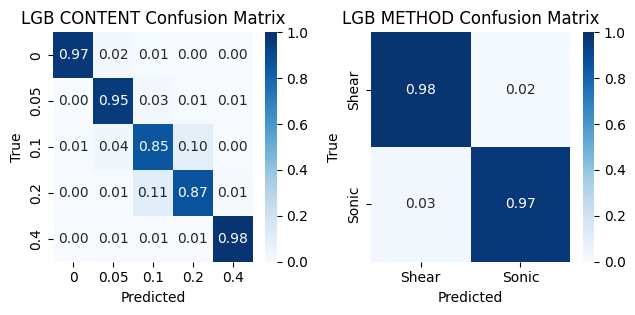

In [ ]:
# 혼동 행렬을 계산합니다.
cm_content_lgb = confusion_matrix(y_test.argmax(axis=1), y_pred_content_lgb)
cm_method_lgb = confusion_matrix(y_test_method, y_pred_method_lgb)

# 혼동 행렬을 정규화합니다.
cm_content_lgb_norm = cm_content_lgb.astype('float') / cm_content_lgb.sum(axis=1)[:, np.newaxis]
cm_method_lgb_norm = cm_method_lgb.astype('float') / cm_method_lgb.sum(axis=1)[:, np.newaxis]

# 시각화를 위한 설정입니다.
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.25))

CONTENTS = [0, 0.05, 0.1, 0.2, 0.4]
METHODS = ['Shear', 'Sonic']

# LGB CONTENT 혼동 행렬을 시각화합니다.
sns.heatmap(cm_content_lgb_norm, annot=True, fmt=".2f", ax=axs[0], cmap='Blues', xticklabels=CONTENTS, yticklabels=CONTENTS, vmin=0, vmax=1)
axs[0].set_title('LGB CONTENT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

# LGB METHOD 혼동 행렬을 시각화합니다.
sns.heatmap(cm_method_lgb_norm, annot=True, fmt=".2f", ax=axs[1], cmap='Blues', xticklabels=METHODS, yticklabels=METHODS, vmin=0, vmax=1)
axs[1].set_title('LGB METHOD Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('/content/drive/My Drive/Results/RGB/confusion_matrix_lgb.svg', format='svg')

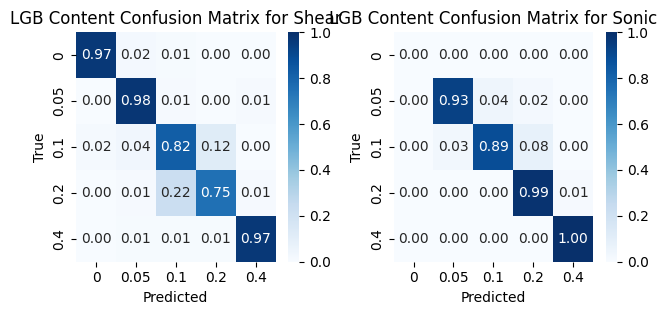

In [ ]:
SHEAR_LABEL = 0
SONIC_LABEL = 1

shear_indices = np.where(y_test_method == SHEAR_LABEL)[0]
sonic_indices = np.where(y_test_method == SONIC_LABEL)[0]

shear_content_true = y_test.argmax(axis=1)[shear_indices]
shear_content_pred = y_pred_content_lgb[shear_indices]

sonic_content_true = y_test.argmax(axis=1)[sonic_indices]
sonic_content_pred = y_pred_content_lgb[sonic_indices]

cm_shear_content = confusion_matrix(shear_content_true, shear_content_pred)
cm_sonic_content = confusion_matrix(sonic_content_true, sonic_content_pred)

cm_shear_content_norm = cm_shear_content.astype('float') / cm_shear_content.sum(axis=1)[:, np.newaxis]
cm_sonic_content_norm = cm_sonic_content.astype('float') / cm_sonic_content.sum(axis=1)[:, np.newaxis]
cm_sonic_content_norm_with_zero = np.zeros((cm_sonic_content_norm.shape[0] + 1, cm_sonic_content_norm.shape[1] + 1))
cm_sonic_content_norm_with_zero[1:, 1:] = cm_sonic_content_norm

fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.25))

sns.heatmap(cm_shear_content_norm, annot=True, fmt=".2f", ax=axs[0], cmap='Blues', xticklabels=CONTENTS, yticklabels=CONTENTS, vmin=0, vmax=1)
axs[0].set_title('LGB Content Confusion Matrix for Shear')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(cm_sonic_content_norm_with_zero, annot=True, fmt=".2f", ax=axs[1], cmap='Blues', xticklabels=[0] + CONTENTS[1:], yticklabels=[0] + CONTENTS[1:], vmin=0, vmax=1)
axs[1].set_title('LGB Content Confusion Matrix for Sonic')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()


In [ ]:
fig.savefig('/content/drive/My Drive/Results/RGB/confusion_matrix_lgb_each.svg', format='svg')

## DL

### CNN Layers

In [ ]:
kernel_size = 7
# filters = [16, 32, 64]
filters = [32, 64, 128]
# filters = [64, 128, 256]

# Input Layer
input_tensor = Input(shape=(256, 3))

# Shared Layers
x = Conv1D(filters=filters[0], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(input_tensor)
x = Dropout(0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=filters[1], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = Conv1D(filters=filters[1], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
# x = Conv1D(filters=filters[1], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
# x = Dropout(0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=filters[2], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = Conv1D(filters=filters[2], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
# x = Conv1D(filters=filters[2], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
# x = Dropout(0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

shared_output = Flatten()(x)

# Sonication Prediction
sonication_output = Dense(1, activation='sigmoid', name='sonication_output')(shared_output)

# Content Prediction
content_output = Dense(5, activation='softmax', name='content_output')(shared_output)

# # Construct the Model
model = Model(inputs=input_tensor, outputs=[sonication_output, content_output])

# Compile the Model
# Assuming primary focus is on 'content' prediction, we can adjust the loss weights accordingly.
WEIGHT = 0.5
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss={'sonication_output': 'binary_crossentropy', 'content_output': 'categorical_crossentropy'},
              loss_weights={'sonication_output': 1-WEIGHT, 'content_output': WEIGHT},
              metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 3)]             0         []                            
                                                                                                  
 conv1d_10 (Conv1D)          (None, 256, 32)              704       ['input_3[0][0]']             
                                                                                                  
 dropout_10 (Dropout)        (None, 256, 32)              0         ['conv1d_10[0][0]']           
                                                                                                  
 max_pooling1d_6 (MaxPoolin  (None, 128, 32)              0         ['dropout_10[0][0]']          
 g1D)                                                                                       

### Train

In [ ]:
# ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "/content/drive/My Drive/Results/RGB/best_cnn_model.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode='min'
)
# EarlyStopping
early_stopping_callback = EarlyStopping(patience=20)

run_results = model.fit(
    x_histo_train,
    {'sonication_output': y_train_method, 'content_output': y_train},
    validation_split=0.15,
    batch_size=32,
    epochs=200,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

model_path = "/content/drive/My Drive/Results/RGB/cnn_model.h5"
model.save(model_path)
print(f"Model saved at {model_path}")

model_path = "/content/drive/My Drive/Results/RGB/best_cnn_model.pkl"
with open(model_path, "wb") as file:
    pickle.dump(run_results.history, file)

Epoch 1/200
122/122 [==============================] - ETA: 0s - loss: 0.6182 - sonication_output_loss: 0.3303 - content_output_loss: 0.9060 - sonication_output_accuracy: 0.8541 - content_output_accuracy: 0.5663
Epoch 1: val_loss improved from inf to 0.49890, saving model to /content/drive/My Drive/Results/RGB/best_cnn_model.h5
122/122 [==============================] - 16s 18ms/step - loss: 0.6182 - sonication_output_loss: 0.3303 - content_output_loss: 0.9060 - sonication_output_accuracy: 0.8541 - content_output_accuracy: 0.5663 - val_loss: 0.4989 - val_sonication_output_loss: 0.2400 - val_content_output_loss: 0.7578 - val_sonication_output_accuracy: 0.9115 - val_content_output_accuracy: 0.7199
Epoch 2/200
 10/122 [=>............................] - ETA: 0s - loss: 0.4159 - sonication_output_loss: 0.2114 - content_output_loss: 0.6203 - sonication_output_accuracy: 0.9156 - content_output_accuracy: 0.7094

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


118/122 [============================>.] - ETA: 0s - loss: 0.3925 - sonication_output_loss: 0.1968 - content_output_loss: 0.5881 - sonication_output_accuracy: 0.9229 - content_output_accuracy: 0.7577
Epoch 2: val_loss improved from 0.49890 to 0.46970, saving model to /content/drive/My Drive/Results/RGB/best_cnn_model.h5
122/122 [==============================] - 1s 7ms/step - loss: 0.3933 - sonication_output_loss: 0.1979 - content_output_loss: 0.5887 - sonication_output_accuracy: 0.9226 - content_output_accuracy: 0.7585 - val_loss: 0.4697 - val_sonication_output_loss: 0.2688 - val_content_output_loss: 0.6706 - val_sonication_output_accuracy: 0.9158 - val_content_output_accuracy: 0.7504
Epoch 3/200
114/122 [===========================>..] - ETA: 0s - loss: 0.3304 - sonication_output_loss: 0.1708 - content_output_loss: 0.4900 - sonication_output_accuracy: 0.9312 - content_output_accuracy: 0.7971
Epoch 3: val_loss improved from 0.46970 to 0.37291, saving model to /content/drive/My Drive/R

### Plot

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


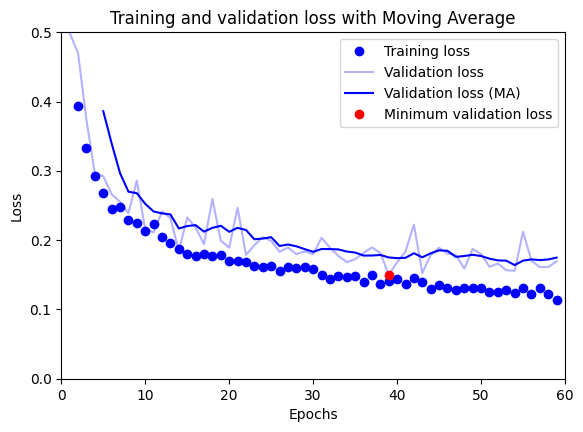

In [ ]:

drive.mount('/content/drive')
model_path = "/content/drive/My Drive/Results/RGB/best_cnn_model.pkl"
with open(model_path, 'rb') as file:
    run_results = pickle.load(file)
history = run_results

train_loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(train_loss) + 1)

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 5
val_loss_ma = moving_average(val_loss, window_size)
valid_epochs = range(window_size, len(train_loss) + 1)
min_val_loss_index = np.argmin(val_loss)
min_val_loss = val_loss[min_val_loss_index]

plt.figure(figsize=(6.5, 4.5))
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', alpha=0.3, label='Validation loss')
plt.plot(valid_epochs, val_loss_ma, 'b', label='Validation loss (MA)')

plt.plot(min_val_loss_index + 1, min_val_loss, 'ro', label='Minimum validation loss')
plt.ylim(0,0.5)
plt.xlim(0,60)
plt.title('Training and validation loss with Moving Average')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('/content/drive/My Drive/Results/RGB/training_curve.svg', format='svg')
plt.show()

26/26 [==============================] - 0s 3ms/step
0.9696092619392185 0.97953216374269 0.9598853868194842
0.9227866762749797 0.9229618231184084 0.9227392380482182


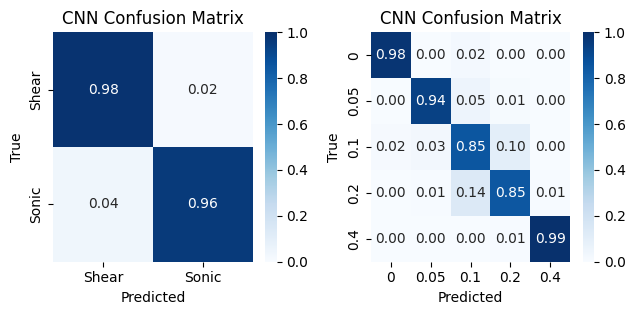

In [ ]:
model_path = "/content/drive/My Drive/Results/RGB/best_cnn_model.h5"

model = tf.keras.models.load_model(model_path)
x_histo_test_reshape = x_histo_test.reshape(-1, 256, 3)
predictions = model.predict(x_histo_test_reshape)
sonication_predictions, content_predictions = predictions

sonication_true = y_test_method
sonication_pred = (sonication_predictions > 0.5).astype(int)  # 시그모이드 출력을 이진 레이블로 변환

sonication_f1 = f1_score(sonication_true, sonication_pred)
sonication_precision = precision_score(sonication_true, sonication_pred)
sonication_recall = recall_score(sonication_true, sonication_pred)

content_true = np.argmax(y_test, axis=1)
content_pred = np.argmax(content_predictions, axis=1)

content_f1 = f1_score(content_true, content_pred, average='macro')
content_precision = precision_score(content_true, content_pred, average='macro')
content_recall = recall_score(content_true, content_pred, average='macro')
print(sonication_f1, sonication_precision, sonication_recall)
print(content_f1, content_precision, content_recall)
sonication_cm = confusion_matrix(sonication_true, sonication_pred)
content_cm = confusion_matrix(content_true, content_pred)

sonication_cm_norm = sonication_cm.astype('float') / sonication_cm.sum(axis=1)[:, np.newaxis]
content_cm_norm = content_cm.astype('float') / content_cm.sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.25))

METHODS = ['Shear','Sonic']
CONTENTS = [0,0.05,0.1,0.2,0.4]
sns.heatmap(sonication_cm_norm, annot=True, fmt=".2f", ax=axs[0], cmap='Blues', xticklabels=METHODS, yticklabels=METHODS, vmin=0, vmax=1)
axs[0].set_title('CNN Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(content_cm_norm, annot=True, fmt=".2f", ax=axs[1], cmap='Blues', xticklabels=CONTENTS, yticklabels=CONTENTS, vmin=0, vmax=1)
axs[1].set_title('CNN Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()


In [ ]:
fig.savefig('/content/drive/My Drive/Results/RGB/confusion_matrix.svg', format='svg')

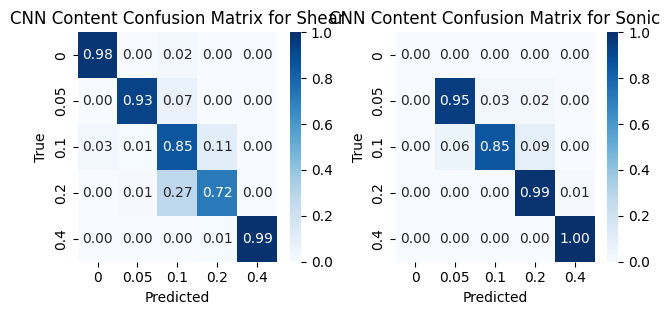

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

SHEAR_LABEL = 0
SONIC_LABEL = 1

shear_indices = np.where(sonication_true == SHEAR_LABEL)[0]
shear_content_true = content_true[shear_indices]
shear_content_pred = content_pred[shear_indices]

sonic_indices = np.where(sonication_true == SONIC_LABEL)[0]
sonic_content_true = content_true[sonic_indices]
sonic_content_pred = content_pred[sonic_indices]

shear_content_cm = confusion_matrix(shear_content_true, shear_content_pred)
sonic_content_cm = confusion_matrix(sonic_content_true, sonic_content_pred)

shear_content_cm_norm = shear_content_cm.astype('float') / shear_content_cm.sum(axis=1)[:, np.newaxis]
sonic_content_cm_norm = sonic_content_cm.astype('float') / sonic_content_cm.sum(axis=1)[:, np.newaxis]
sonic_content_cm_norm_with_zero = np.zeros((sonic_content_cm_norm.shape[0] + 1, sonic_content_cm_norm.shape[1] + 1))
sonic_content_cm_norm_with_zero[1:, 1:] = sonic_content_cm_norm

fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.25))

sns.heatmap(shear_content_cm_norm, annot=True, fmt=".2f", ax=axs[0], cmap='Blues', xticklabels=CONTENTS, yticklabels=CONTENTS, vmin=0, vmax=1)
axs[0].set_title('CNN Content Confusion Matrix for Shear')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(sonic_content_cm_norm_with_zero, annot=True, fmt=".2f", ax=axs[1], cmap='Blues', xticklabels=CONTENTS, yticklabels=CONTENTS, vmin=0, vmax=1)
axs[1].set_title('CNN Content Confusion Matrix for Sonic')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()


In [ ]:
fig.savefig('/content/drive/My Drive/Results/RGB/confusion_matrix_cnn_each.svg', format='svg')

# Model performance with respect to data size

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import time
import numpy as np

def create_cnn_model():
    kernel_size = 7
    filters = [32, 64, 128]

    input_tensor = Input(shape=(256, 3))

    x = Conv1D(filters=filters[0], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(input_tensor)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=filters[1], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=filters[2], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv1D(filters=filters[2], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)

    flatten = Flatten()(x)
    output = Dense(5, activation='softmax')(flatten)
    cnn = Model(inputs=input_tensor, outputs=output)
    cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    cnn.summary()
    return cnn

def model_comparison(ratio):
    idx = int(len(x_histo) * ratio)

    time_arr = []

    models = {
        'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance'),
        'SVM': SVC(C=10, gamma='auto', kernel='rbf'),
        'RF': RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=200),
        'LGB': lgb.LGBMClassifier(),
        'CNN-1D': create_cnn_model() # CNN 모델을 여기서 생성합니다
    }

    for model_name, model in models.items():
        if model_name in ['KNN', 'SVM']:
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                (model_name.lower(), model)
            ])
            start_time = time.time()
            pipe.fit(x_histo[:idx], y_train[:idx].argmax(axis=1))
            end_time = time.time()
            accuracy = accuracy_score(y_test.argmax(axis=1), pipe.predict(x_histo_test))

        elif model_name in ['RF', 'LGB']:
            start_time = time.time()
            model.fit(x_histo[:idx], y_train[:idx].argmax(axis=1))
            end_time = time.time()
            accuracy = accuracy_score(y_test.argmax(axis=1), model.predict(x_histo_test))

        elif model_name == 'CNN-1D':
            early_stopping_callback = EarlyStopping(patience=20)

            start_time = time.time()
            history = model.fit(x_histo_train[:idx], y_train[:idx], validation_split=0.15,
                                batch_size=32, epochs=200,
                                callbacks=[early_stopping_callback])
            end_time = time.time()

            x_histo_test_reshape = x_histo_test.reshape(-1, 256, 3)
            predictions = model.predict(x_histo_test_reshape)
            accuracy = accuracy_score(y_test.argmax(axis=1), np.argmax(predictions, axis=1))

        timestemp = end_time - start_time
        time_arr.append((model_name, timestemp, accuracy))

        print(f"Test accuracy for CONTENT with default {model_name} parameters: {accuracy}")
        print(f"{model_name} runtime: {timestemp} seconds")

    return time_arr


In [ ]:
dataset50

[('KNN', 0.025782108306884766, 0.8641975308641975),
 ('SVM', 0.6934947967529297, 0.8814814814814815),
 ('RF', 3.639587163925171, 0.9012345679012346),
 ('LGB', 6.467048406600952, 0.9123456790123456),
 ('CNN-1D', 42.755757570266724, 0.8987654320987655)]

In [ ]:
dataset75 = model_comparison(0.75)

Test accuracy for CONTENT with default KNN parameters: 0.8790123456790123
KNN runtime: 0.03419208526611328 seconds
Test accuracy for CONTENT with default SVM parameters: 0.8925925925925926
SVM runtime: 1.3591604232788086 seconds
Test accuracy for CONTENT with default RF parameters: 0.9037037037037037
RF runtime: 5.661958694458008 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119728
[LightGBM] [Info] Number of data points in the train set: 3442, number of used features: 623
[LightGBM] [Info] Start training from score -2.187971
[LightGBM] [Info] Start training from score -1.509175
[LightGBM] [Info] Start training from score -1.538510
[LightGBM] [Info] Start training from score -1.488368
[LightGBM] [Info] Start training from score -1.485797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [ ]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from tensorflow.keras.callbacks import EarlyStopping
def create_cnn_model():
    kernel_size = 7
    filters = [32, 64, 128]

    input_tensor = Input(shape=(256, 3))

    x = Conv1D(filters=filters[0], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(input_tensor)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=filters[1], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv1D(filters=filters[1], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=filters[2], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv1D(filters=filters[2], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)

    shared_output = Flatten()(x)
    sonication_output = Dense(1, activation='sigmoid', name='sonication_output')(shared_output)
    content_output = Dense(5, activation='softmax', name='content_output')(shared_output)
    cnn = Model(inputs=input_tensor, outputs=[sonication_output, content_output])

    WEIGHT = 0.5
    cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss={'sonication_output': 'binary_crossentropy', 'content_output': 'categorical_crossentropy'},
                  loss_weights={'sonication_output': 1-WEIGHT, 'content_output': WEIGHT},
                  metrics=['accuracy'])

    cnn.summary()
    return cnn
def model_comparison(ratio):
    idx = int(len(x_histo) * ratio)

    time_arr = []

    models = {
        'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance'),
        'SVM': SVC(C=10, gamma='auto', kernel='rbf'),
        'RF': RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=200),
        'LGB': lgb.LGBMClassifier(),
        'CNN-1D': create_cnn_model()
    }

    for model_name, model in models.items():
        if model_name in ['KNN', 'SVM']:
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                (model_name.lower(), model)
            ])
            start_time = time.time()
            pipe.fit(x_histo[:idx], y_train[:idx].argmax(axis=1))
            train_end_time = time.time()

            start_pred_time = time.time()
            predictions = pipe.predict(x_histo_test)
            pred_end_time = time.time()

            accuracy = accuracy_score(y_test.argmax(axis=1), predictions)

        elif model_name in ['RF', 'LGB']:
            start_time = time.time()
            model.fit(x_histo[:idx], y_train[:idx].argmax(axis=1))
            train_end_time = time.time()

            start_pred_time = time.time()
            predictions = model.predict(x_histo_test)
            pred_end_time = time.time()

            accuracy = accuracy_score(y_test.argmax(axis=1), predictions)

        elif model_name == 'CNN-1D':
            early_stopping_callback = EarlyStopping(patience=20)

            start_time = time.time()
            history = model.fit(x_histo_train[:idx],
                                {'sonication_output': y_train_method[:idx], 'content_output': y_train[:idx]},
                                validation_split=0.15,
                                batch_size=32, epochs=200,
                                callbacks=[early_stopping_callback])
            train_end_time = time.time()

            x_histo_test_reshape = x_histo_test.reshape(-1, 256, 3)
            start_pred_time = time.time()
            sonication, predictions = model.predict(x_histo_test_reshape)
            pred_end_time = time.time()

            accuracy = accuracy_score(y_test.argmax(axis=1), np.argmax(predictions, axis=1))

        train_time = train_end_time - start_time
        pred_time = pred_end_time - start_pred_time
        total_time = train_time + pred_time
        time_arr.append((model_name, total_time, train_time, pred_time, accuracy))  # Save model name, total time, train time, pred time and accuracy to array

        print(f"Test accuracy for CONTENT with {model_name} parameters: {accuracy}")
        print(f"{model_name} total runtime: {total_time} seconds (Train time: {train_time}, Prediction time: {pred_time})")

    return time_arr

dataset50 = model_comparison(0.5)
dataset75 = model_comparison(0.75)
datasetAll = model_comparison(1)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 3)]             0         []                            
                                                                                                  
 conv1d_15 (Conv1D)          (None, 256, 32)              704       ['input_4[0][0]']             
                                                                                                  
 dropout_15 (Dropout)        (None, 256, 32)              0         ['conv1d_15[0][0]']           
                                                                                                  
 max_pooling1d_9 (MaxPoolin  (None, 128, 32)              0         ['dropout_15[0][0]']          
 g1D)                                                                                       

In [ ]:
dataset50

[('KNN',
  0.5113592147827148,
  0.02529001235961914,
  0.4860692024230957,
  0.8641975308641975),
 ('SVM',
  1.2315056324005127,
  0.6984741687774658,
  0.5330314636230469,
  0.8814814814814815),
 ('RF',
  3.687009811401367,
  3.64158034324646,
  0.04542946815490723,
  0.8987654320987655),
 ('LGB',
  7.021546840667725,
  7.009490728378296,
  0.012056112289428711,
  0.9123456790123456),
 ('CNN-1D',
  42.000195264816284,
  41.754411935806274,
  0.24578332901000977,
  0.8888888888888888)]

In [ ]:
dataset75

[('KNN',
  0.8491933345794678,
  0.04221343994140625,
  0.8069798946380615,
  0.8790123456790123),
 ('SVM',
  2.2027904987335205,
  1.4374842643737793,
  0.7653062343597412,
  0.8925925925925926),
 ('RF',
  5.880969762802124,
  5.835013389587402,
  0.04595637321472168,
  0.9049382716049382),
 ('LGB',
  8.096549987792969,
  8.085800409317017,
  0.010749578475952148,
  0.9160493827160494),
 ('CNN-1D',
  77.21604657173157,
  76.99178075790405,
  0.22426581382751465,
  0.9049382716049382)]

In [ ]:
datasetAll

[('KNN',
  0.7903904914855957,
  0.0441288948059082,
  0.7462615966796875,
  0.8753086419753087),
 ('SVM',
  2.8542728424072266,
  2.061048746109009,
  0.7932240962982178,
  0.8938271604938272),
 ('RF',
  8.038781881332397,
  7.995032787322998,
  0.043749094009399414,
  0.9098765432098765),
 ('LGB',
  8.408802032470703,
  8.398496866226196,
  0.010305166244506836,
  0.9259259259259259),
 ('CNN-1D',
  86.52152442932129,
  86.27553582191467,
  0.2459886074066162,
  0.9148148148148149)]